# IMPORT

In [5]:
%pip install xgboost lightgbm catboost optuna matplolib seaborn

ERROR: Could not find a version that satisfies the requirement matplolib (from versions: none)
ERROR: No matching distribution found for matplolib


In [6]:
# ADVANCED TREE-BASED ENSEMBLE WITH STACKING
# Combines LightGBM, XGBoost, and CatBoost with meta-learning

import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import optuna  # For hyperparameter optimization
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("ADVANCED TREE-BASED STACKING PIPELINE")
print("="*60)

# ============================================
# 1. LOAD AND PREPARE DATA
# ============================================

print("\n📁 Loading data...")

train_df = pd.read_csv('/content/drive/MyDrive/giki-solar-energy-prediction-challenge/train_data.csv')
test_df_original = pd.read_csv('/content/drive/MyDrive/giki-solar-energy-prediction-challenge/test_data_masked.csv')
systems_df = pd.read_csv('/content/drive/MyDrive/giki-solar-energy-prediction-challenge/systems_new.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/giki-solar-energy-prediction-challenge/sample_submissions.csv')

# Convert timestamps
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df_original['timestamp'] = pd.to_datetime(test_df_original['timestamp'])

# Fix capacity units
systems_df['panels_capacity_W'] = systems_df['panels_capacity'] * 1000
systems_df['load_capacity_W'] = systems_df['load_capacity'] * 1000

print(f"✅ Loaded {len(train_df):,} training samples")

ADVANCED TREE-BASED STACKING PIPELINE

📁 Loading data...
✅ Loaded 3,686,726 training samples


# EDA

In [7]:
# ============================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*60)

# Merge train data with systems for EDA
train_eda = train_df.merge(
    systems_df[['system_id', 'panels_capacity_W', 'load_capacity_W', 'connection_type', 'location']],
    on='system_id', how='left'
)

# Add time features for EDA
train_eda['hour'] = train_eda['timestamp'].dt.hour
train_eda['day_of_week'] = train_eda['timestamp'].dt.dayofweek
train_eda['month'] = train_eda['timestamp'].dt.month

# ============================================
# 2.1 BASIC STATISTICS
# ============================================

print("\n📈 Basic Statistics:")
print("-"*40)

# Target variables statistics
print("\n🎯 Target Variables:")
print(f"Generation (W):")
print(f"  Mean: {train_eda['generation_W'].mean():.2f}")
print(f"  Median: {train_eda['generation_W'].median():.2f}")
print(f"  Std: {train_eda['generation_W'].std():.2f}")
print(f"  Min: {train_eda['generation_W'].min():.2f}")
print(f"  Max: {train_eda['generation_W'].max():.2f}")

print(f"\nLoad (W):")
print(f"  Mean: {train_eda['load_W'].mean():.2f}")
print(f"  Median: {train_eda['load_W'].median():.2f}")
print(f"  Std: {train_eda['load_W'].std():.2f}")
print(f"  Min: {train_eda['load_W'].min():.2f}")
print(f"  Max: {train_eda['load_W'].max():.2f}")

# System characteristics
print("\n🏭 System Characteristics:")
print(f"Unique systems: {train_eda['system_id'].nunique()}")
print(f"Unique locations: {train_eda['location'].nunique()}")
print(f"Connection types: {train_eda['connection_type'].value_counts().to_dict()}")

# Missing values
print("\n❓ Missing Values:")
missing = train_eda.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found! ✅")


📊 EXPLORATORY DATA ANALYSIS

📈 Basic Statistics:
----------------------------------------

🎯 Target Variables:
Generation (W):
  Mean: 1746.77
  Median: 36.00
  Std: 3186.00
  Min: 0.00
  Max: 52224.00

Load (W):
  Mean: 1579.16
  Median: 889.00
  Std: 2001.36
  Min: 0.00
  Max: 33771.97

🏭 System Characteristics:
Unique systems: 80
Unique locations: 18
Connection types: {'RESIDENTIAL': 2438236, 'COMMERCIAL': 1407592}

❓ Missing Values:
No missing values found! ✅



📊 Correlation Analysis:
----------------------------------------


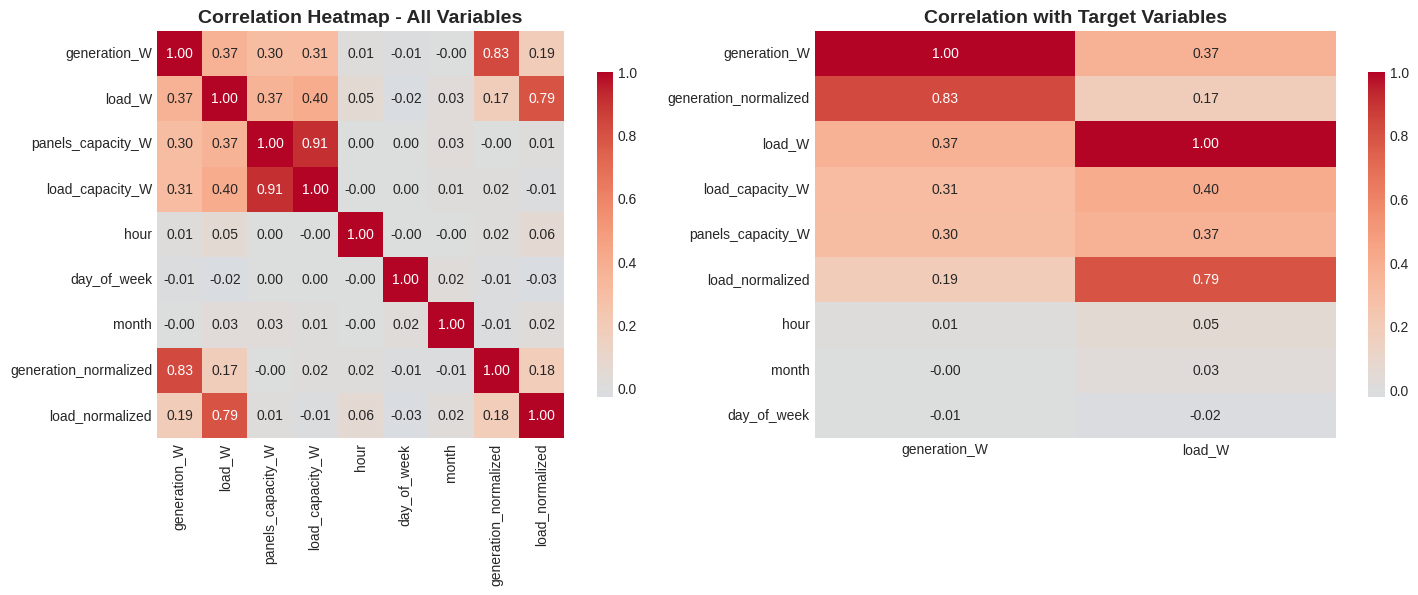


🔑 Key Correlations with Generation:
  generation_normalized: 0.833
  load_W: 0.370
  load_capacity_W: 0.307
  panels_capacity_W: 0.303
  load_normalized: 0.190

🔑 Key Correlations with Load:
  load_normalized: 0.788
  load_capacity_W: 0.403
  generation_W: 0.370
  panels_capacity_W: 0.369
  generation_normalized: 0.175


In [8]:
# ============================================
# 2.2 CORRELATION ANALYSIS
# ============================================

print("\n📊 Correlation Analysis:")
print("-"*40)

# Select numerical columns for correlation
corr_cols = ['generation_W', 'load_W', 'panels_capacity_W', 'load_capacity_W',
             'hour', 'day_of_week', 'month']
corr_data = train_eda[corr_cols].copy()

# Add normalized targets for correlation
corr_data['generation_normalized'] = train_eda['generation_W'] / (train_eda['panels_capacity_W'] + 1)
corr_data['load_normalized'] = train_eda['load_W'] / (train_eda['load_capacity_W'] + 1)

# Calculate correlation matrix
correlation_matrix = corr_data.corr()

# Create correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title('Correlation Heatmap - All Variables', fontsize=14, fontweight='bold')

# Target correlations only
target_corr = correlation_matrix[['generation_W', 'load_W']].sort_values(by='generation_W', ascending=False)
sns.heatmap(target_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title('Correlation with Target Variables', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print key correlations
print("\n🔑 Key Correlations with Generation:")
gen_corr = correlation_matrix['generation_W'].sort_values(ascending=False)[1:6]
for feature, corr in gen_corr.items():
    print(f"  {feature}: {corr:.3f}")

print("\n🔑 Key Correlations with Load:")
load_corr = correlation_matrix['load_W'].sort_values(ascending=False)[1:6]
for feature, corr in load_corr.items():
    print(f"  {feature}: {corr:.3f}")


📉 Distribution Analysis:
----------------------------------------


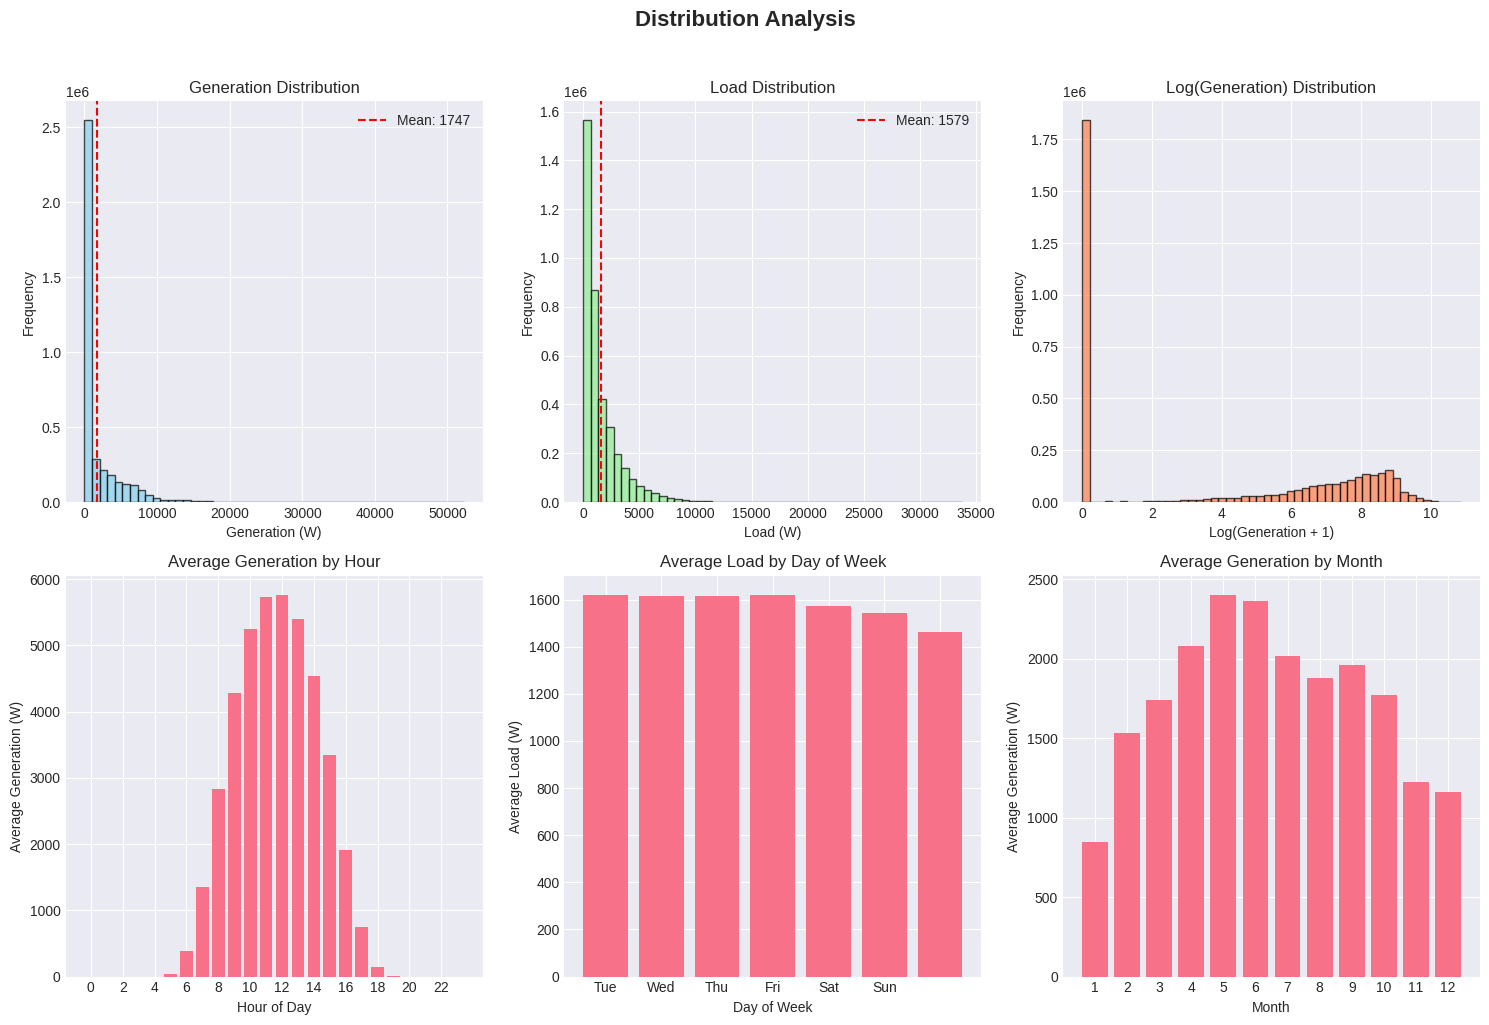

In [9]:
# ============================================
# 2.3 DISTRIBUTION ANALYSIS
# ============================================

print("\n📉 Distribution Analysis:")
print("-"*40)

# Create distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)

# Generation distribution
axes[0, 0].hist(train_eda['generation_W'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Generation Distribution')
axes[0, 0].set_xlabel('Generation (W)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_eda['generation_W'].mean(), color='red', linestyle='--', label=f'Mean: {train_eda["generation_W"].mean():.0f}')
axes[0, 0].legend()

# Load distribution
axes[0, 1].hist(train_eda['load_W'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Load Distribution')
axes[0, 1].set_xlabel('Load (W)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_eda['load_W'].mean(), color='red', linestyle='--', label=f'Mean: {train_eda["load_W"].mean():.0f}')
axes[0, 1].legend()

# Log-transformed distributions
axes[0, 2].hist(np.log1p(train_eda['generation_W']), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 2].set_title('Log(Generation) Distribution')
axes[0, 2].set_xlabel('Log(Generation + 1)')
axes[0, 2].set_ylabel('Frequency')

# Hour distribution
axes[1, 0].bar(range(24), train_eda.groupby('hour')['generation_W'].mean().values)
axes[1, 0].set_title('Average Generation by Hour')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Generation (W)')
axes[1, 0].set_xticks(range(0, 24, 2))

# Day of week distribution
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), train_eda.groupby('day_of_week')['load_W'].mean().values)
axes[1, 1].set_title('Average Load by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Load (W)')
axes[1, 1].set_xticklabels(days)

# Month distribution
axes[1, 2].bar(range(1, 13), train_eda.groupby('month')['generation_W'].mean().reindex(range(1, 13), fill_value=0).values)
axes[1, 2].set_title('Average Generation by Month')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Average Generation (W)')
axes[1, 2].set_xticks(range(1, 13))

plt.tight_layout()
plt.savefig('distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


⏰ Time Series Patterns:
----------------------------------------


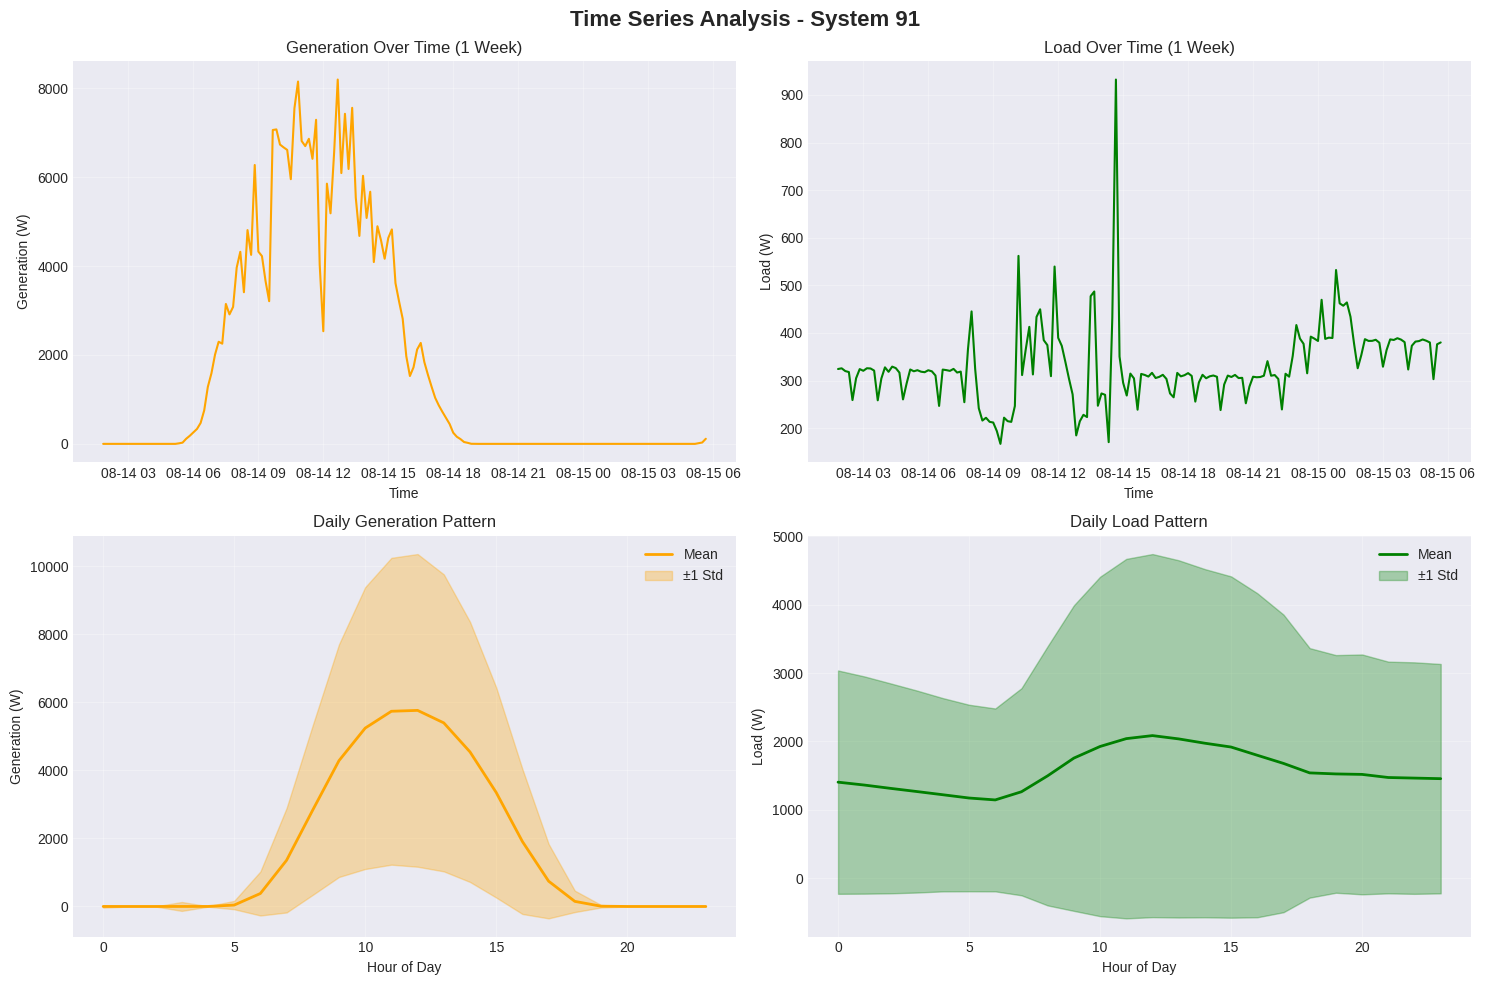


💡 Key Insights:
  • Peak generation hour: 12:00 (5761 W)
  • Peak load hour: 12:00 (2086 W)
  • Generation starts rising at: ~6:00
  • Generation peaks at: ~12:00
  • Load pattern: Variable throughout day


In [10]:
# ============================================
# 2.4 TIME SERIES PATTERNS
# ============================================

print("\n⏰ Time Series Patterns:")
print("-"*40)

# Sample a random system for time series visualization
sample_system = train_eda['system_id'].sample(1).values[0]
system_data = train_eda[train_eda['system_id'] == sample_system].sort_values('timestamp')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Time Series Analysis - System {sample_system}', fontsize=16, fontweight='bold')

# Generation over time (1 week sample)
week_data = system_data.head(24*7)
axes[0, 0].plot(week_data['timestamp'], week_data['generation_W'], color='orange', linewidth=1.5)
axes[0, 0].set_title('Generation Over Time (1 Week)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Generation (W)')
axes[0, 0].grid(True, alpha=0.3)

# Load over time (1 week sample)
axes[0, 1].plot(week_data['timestamp'], week_data['load_W'], color='green', linewidth=1.5)
axes[0, 1].set_title('Load Over Time (1 Week)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Load (W)')
axes[0, 1].grid(True, alpha=0.3)

# Daily pattern - Generation
hourly_gen = train_eda.groupby('hour')['generation_W'].agg(['mean', 'std'])
axes[1, 0].plot(hourly_gen.index, hourly_gen['mean'], color='orange', linewidth=2, label='Mean')
axes[1, 0].fill_between(hourly_gen.index,
                        hourly_gen['mean'] - hourly_gen['std'],
                        hourly_gen['mean'] + hourly_gen['std'],
                        alpha=0.3, color='orange', label='±1 Std')
axes[1, 0].set_title('Daily Generation Pattern')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Generation (W)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Daily pattern - Load
hourly_load = train_eda.groupby('hour')['load_W'].agg(['mean', 'std'])
axes[1, 1].plot(hourly_load.index, hourly_load['mean'], color='green', linewidth=2, label='Mean')
axes[1, 1].fill_between(hourly_load.index,
                        hourly_load['mean'] - hourly_load['std'],
                        hourly_load['mean'] + hourly_load['std'],
                        alpha=0.3, color='green', label='±1 Std')
axes[1, 1].set_title('Daily Load Pattern')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Load (W)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('timeseries_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print insights
print("\n💡 Key Insights:")
print(f"  • Peak generation hour: {hourly_gen['mean'].idxmax()}:00 ({hourly_gen['mean'].max():.0f} W)")
print(f"  • Peak load hour: {hourly_load['mean'].idxmax()}:00 ({hourly_load['mean'].max():.0f} W)")
print(f"  • Generation starts rising at: ~6:00")
print(f"  • Generation peaks at: ~{hourly_gen['mean'].idxmax()}:00")
print(f"  • Load pattern: {'More consistent throughout day' if hourly_load['std'].mean() < hourly_gen['std'].mean() else 'Variable throughout day'}")

# FEATURE ENGINEERING AND SELECTION

In [11]:
# ============================================
# 2. ENHANCED FEATURE ENGINEERING
# ============================================

def create_advanced_features(df, systems_df, top_locations=None):
    """Create more sophisticated features with consistent location encoding"""

    # Merge with systems
    df = df.merge(systems_df[['system_id', 'panels_capacity_W', 'load_capacity_W',
                              'connection_type', 'location']],
                  on='system_id', how='left')

    # Time features
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['quarter'] = df['timestamp'].dt.quarter
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Enhanced solar features
    df['solar_elevation'] = np.where(
        (df['hour'] >= 6) & (df['hour'] <= 18),
        np.sin(np.pi * (df['hour'] - 6) / 12),
        0
    )

    # Solar intensity approximation (considers time and season)
    summer_factor = np.sin(np.pi * (df['day_of_year'] - 80) / 365)  # Peak around June
    df['solar_intensity'] = df['solar_elevation'] * (1 + 0.3 * summer_factor)
    df['solar_intensity'] = df['solar_intensity'].clip(0, 1.3)

    # Peak hours with granularity
    df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['is_solar_peak'] = ((df['hour'] >= 11) & (df['hour'] <= 14)).astype(int)
    df['is_afternoon_peak'] = ((df['hour'] >= 15) & (df['hour'] <= 17)).astype(int)
    df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)
    df['is_night'] = ((df['hour'] <= 5) | (df['hour'] >= 22)).astype(int)

    # System features
    df['is_residential'] = (df['connection_type'] == 'RESIDENTIAL').astype(int)
    df['is_commercial'] = (df['connection_type'] == 'COMMERCIAL').astype(int)

    # Capacity features
    df['capacity_ratio'] = df['panels_capacity_W'] / (df['load_capacity_W'] + 1)
    df['log_panels_capacity'] = np.log1p(df['panels_capacity_W'])
    df['log_load_capacity'] = np.log1p(df['load_capacity_W'])
    df['total_capacity'] = df['panels_capacity_W'] + df['load_capacity_W']

    # Interaction features
    df['solar_x_capacity'] = df['solar_elevation'] * df['panels_capacity_W']
    df['hour_x_residential'] = df['hour'] * df['is_residential']
    df['hour_x_commercial'] = df['hour'] * df['is_commercial']
    df['weekend_x_residential'] = df['day_of_week'].isin([5, 6]).astype(int) * df['is_residential']

    # FIX: Location encoding with consistent features
    if top_locations is not None:
        # Use provided top locations (from training data)
        for loc in top_locations:
            df[f'loc_{loc}'] = (df['location'] == loc).astype(int)
    else:
        # This is training data, determine top locations
        top_locations = df['location'].value_counts().head(10).index
        for loc in top_locations:
            df[f'loc_{loc}'] = (df['location'] == loc).astype(int)

    # Advanced time features
    df['minutes_from_noon'] = np.abs((df['hour'] * 60 + df['minute']) - 720)
    df['minutes_from_midnight'] = np.minimum(
        df['hour'] * 60 + df['minute'],
        1440 - (df['hour'] * 60 + df['minute'])
    )

    return df, top_locations

# REPLACE the feature engineering section with this:

print("\n🔧 Creating advanced features...")

# Process training data and get top locations
train_processed, top_locations_from_train = create_advanced_features(train_df.copy(), systems_df.copy())

# Process test data using the same top locations from training
test_processed, _ = create_advanced_features(test_df_original.copy(), systems_df.copy(), top_locations=top_locations_from_train)

# CRITICAL: Normalize targets - Moved before feature selection
train_processed['generation_normalized'] = (
    train_processed['generation_W'] / (train_processed['panels_capacity_W'] + 1)
).clip(0, 1.5)
train_processed['load_normalized'] = (
    train_processed['load_W'] / (train_processed['load_capacity_W'] + 1)
).clip(0, 2.0)

print(f"✅ Created {len(train_processed.columns)} features")
print(f"✅ Top locations used: {list(top_locations_from_train)}")

# Now verify features match - Adjusted logic
train_cols = set(train_processed.columns)
test_cols = set(test_processed.columns)

# Identify columns unique to each set (excluding test_id from this check)
unique_to_train = train_cols - test_cols - {'generation_normalized', 'load_normalized'}
unique_to_test = test_cols - train_cols - {'test_id'}

if unique_to_train:
    print(f"⚠️ Columns unique to train: {unique_to_train}")
    # Drop columns unique to train from train_processed (except target variables)
    train_processed = train_processed.drop(columns=list(unique_to_train), errors='ignore')

if unique_to_test:
    print(f"⚠️ Columns unique to test: {unique_to_test}")
    # Drop columns unique to test from test_processed
    test_processed = test_processed.drop(columns=list(unique_to_test), errors='ignore')

# Ensure column order is the same for train and test (excluding test_id from test)
common_cols = [col for col in train_processed.columns if col in test_processed.columns]
train_processed = train_processed[common_cols + ['generation_normalized', 'load_normalized']] # Keep targets in train
test_processed = test_processed[common_cols + ['test_id']] # Keep test_id in test

# Add a check to ensure feature columns match after dropping
feature_cols_train_check = set(train_processed.columns) - {'generation_normalized', 'load_normalized'}
feature_cols_test_check = set(test_processed.columns) - {'test_id'}

if feature_cols_train_check != feature_cols_test_check:
     print("❌ Error: Feature columns in train_processed and test_processed do not match after dropping!")
     print("Features in train_processed:", sorted(list(feature_cols_train_check)))
     print("Features in test_processed:", sorted(list(feature_cols_test_check)))
else:
     print("✅ Feature columns in train_processed and test_processed match.")


# ============================================
# 3. FEATURE SELECTION
# ============================================

# Select features (exclude identifiers and targets)
exclude_cols = ['timestamp', 'system_id', 'generation_W', 'load_W',
                'connection_type',
                'location', 'test_id', 'generation_normalized', 'load_normalized'] # Explicitly exclude normalized targets
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

print(f"📊 Using {len(feature_cols)} features for modeling")

X_train = train_processed[feature_cols]
y_train_gen = train_processed['generation_normalized']
y_train_load = train_processed['load_normalized']
X_test = test_processed[feature_cols]


🔧 Creating advanced features...
✅ Created 52 features
✅ Top locations used: ['LAHORE', 'KARACHI', 'ISLAMABAD', 'SIALKOT', 'RAWALPINDI', 'HYDERABAD', 'PESHAWAR', 'GUJRANWALA', 'SWAT', 'MARDAN']
✅ Feature columns in train_processed and test_processed match.
📊 Using 44 features for modeling


# MODEL TRAINING

In [14]:
# ============================================
# 4. LIGHTGBM WITH HYPERPARAMETER TUNING
# ============================================

print("\n" + "="*60)
print("OPTIMIZED LIGHTGBM MODELS")
print("="*60)

import lightgbm as lgb

def train_lgb_with_cv(X, y, params=None, n_folds=5):
    """Train LightGBM with cross-validation"""

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 50,
            'learning_rate': 0.02,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'verbose': -1,
            'num_threads': -1
        }

    # Cross-validation for robust training
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    models = []
    scores = []
    # Store validation indices from the last fold
    last_val_idx = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(50),
                lgb.log_evaluation(0)
            ]
        )

        models.append(model)
        val_pred = model.predict(X_fold_val, num_iteration=model.best_iteration)
        mae = mean_absolute_error(y_fold_val, val_pred)
        scores.append(mae)
        print(f"  Fold {fold} MAE: {mae:.5f}")

        last_val_idx = val_idx # Store indices from this fold

    print(f"  Average MAE: {np.mean(scores):.5f} (±{np.std(scores):.5f})")
    return models, last_val_idx

# Train generation models
print("\n📊 Training LightGBM for generation...")
lgb_gen_models, lgb_gen_val_idx = train_lgb_with_cv(X_train, y_train_gen)

# Train load models
print("\n📊 Training LightGBM for load...")
lgb_load_models, lgb_load_val_idx = train_lgb_with_cv(X_train, y_train_load)

# ============================================
# 5. XGBOOST MODELS
# ============================================

print("\n" + "="*60)
print("XGBOOST MODELS")
print("="*60)

try:
    import xgboost as xgb

    def train_xgb_with_cv(X, y, n_folds=5):
        """Train XGBoost with cross-validation"""

        params = {
            'objective': 'reg:absoluteerror',
            'max_depth': 6,
            'learning_rate': 0.02,
            'n_estimators': 1000,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }

        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        models = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBRegressor(
                **params,
                eval_metric='mae',
                early_stopping_rounds=50
            )
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                verbose=False
            )

            models.append(model)
            print(f"  Fold {fold} trained")

        return models

    print("📊 Training XGBoost for generation...")
    xgb_gen_models = train_xgb_with_cv(X_train, y_train_gen)

    print("📊 Training XGBoost for load...")
    xgb_load_models = train_xgb_with_cv(X_train, y_train_load)

    USE_XGBOOST = True
except ImportError:
    print("⚠️ XGBoost not available")
    USE_XGBOOST = False

# ============================================
# 6. CATBOOST MODELS
# ============================================

print("\n" + "="*60)
print("CATBOOST MODELS")
print("="*60)

try:
    import catboost as cb

    def train_catboost_with_cv(X, y, n_folds=3):
        """Train CatBoost with cross-validation"""

        params = {
            'loss_function': 'MAE',
            'iterations': 1000,
            'learning_rate': 0.03,
            'depth': 6,
            'l2_leaf_reg': 3,
            'random_seed': 42,
            'verbose': False
        }

        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        models = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            model = cb.CatBoostRegressor(**params)
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=(X_fold_val, y_fold_val),
                early_stopping_rounds=50,
                verbose=False
            )

            models.append(model)
            print(f"  Fold {fold} trained")

        return models

    print("📊 Training CatBoost for generation...")
    cb_gen_models = train_catboost_with_cv(X_train, y_train_gen)

    print("📊 Training CatBoost for load...")
    cb_load_models = train_catboost_with_cv(X_train, y_train_load)

    USE_CATBOOST = True
except ImportError:
    print("⚠️ CatBoost not available")
    USE_CATBOOST = False

# ============================================
# 7. STACKING WITH META-LEARNER
# ============================================

print("\n" + "="*60)
print("STACKING ENSEMBLE")
print("="*60)

def create_meta_features(models_list, X, model_type='lgb'):
    """Create predictions from base models for meta-learner"""
    predictions = []

    for model in models_list:
        if model_type == 'lgb':
            pred = model.predict(X, num_iteration=model.best_iteration)
        else:
            pred = model.predict(X)
        predictions.append(pred)

    # Return mean and std of predictions
    preds_array = np.array(predictions)
    return np.mean(preds_array, axis=0), np.std(preds_array, axis=0)

# Create meta features for training
print("Creating meta features...")
meta_train_gen = []
meta_train_load = []

# LightGBM predictions
lgb_gen_mean, lgb_gen_std = create_meta_features(lgb_gen_models, X_train, 'lgb')
lgb_load_mean, lgb_load_std = create_meta_features(lgb_load_models, X_train, 'lgb')
meta_train_gen.extend([lgb_gen_mean, lgb_gen_std])
meta_train_load.extend([lgb_load_mean, lgb_load_std])

if USE_XGBOOST:
    xgb_gen_mean, xgb_gen_std = create_meta_features(xgb_gen_models, X_train, 'xgb')
    xgb_load_mean, xgb_load_std = create_meta_features(xgb_load_models, X_train, 'xgb')
    meta_train_gen.extend([xgb_gen_mean, xgb_gen_std])
    meta_train_load.extend([xgb_load_mean, xgb_load_std])

if USE_CATBOOST:
    cb_gen_mean, cb_gen_std = create_meta_features(cb_gen_models, X_train, 'cb')
    cb_load_mean, cb_load_std = create_meta_features(cb_load_models, X_train, 'cb')
    meta_train_gen.extend([cb_gen_mean, cb_gen_std])
    meta_train_load.extend([cb_load_mean, cb_load_std])

# Stack meta features
X_meta_gen = np.column_stack(meta_train_gen)
X_meta_load = np.column_stack(meta_train_load)

print(f"Meta features shape: {X_meta_gen.shape}")

# Train meta-learners (simple linear model to avoid overfitting)
print("\nTraining meta-learners...")
meta_model_gen = Ridge(alpha=1.0)
meta_model_gen.fit(X_meta_gen, y_train_gen)

meta_model_load = Ridge(alpha=1.0)
meta_model_load.fit(X_meta_load, y_train_load)

print("✅ Meta-learners trained")


OPTIMIZED LIGHTGBM MODELS

📊 Training LightGBM for generation...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0355125
  Fold 1 MAE: 0.03551
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0353723
  Fold 2 MAE: 0.03537
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0354891
  Fold 3 MAE: 0.03549
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0352997
  Fold 4 MAE: 0.03530
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0355086
  Fold 5 MAE: 0.03551
  Average MAE: 0.03544 (±0.00009)

📊 Training LightGBM for load...
Training until validation scores don't improve for 50 rou

# GRAPH AND RESULTS


VALIDATION ANALYSIS - FORECAST VS ACTUAL

📊 Generation Metrics:
   MAE (Mean Absolute Error): 413.39 W
   RMSE: 946.67 W
   MAPE: 18780089405604.36%
   Average Difference (Pred - Actual): -2.30 W
   ⬇️ Tends to underpredict
   ⚠️ Most errors occur at hours: [12, 11, 13]

📊 Load Metrics:
   MAE (Mean Absolute Error): 549.66 W
   RMSE: 911.71 W
   MAPE: 12294086845628.45%
   Average Difference (Pred - Actual): -3.89 W
   ⬇️ Tends to underpredict
   ⚠️ Most errors occur at hours: [15, 13, 14]

📁 SAMPLE VALIDATION RESULTS (First 5 predictions)

🔍 Sample 1:
  Generation:
    Actual:     0.00 W
    Predicted:     4.76 W
    Difference:     4.76 W (+inf%)
  Load:
    Actual:   520.81 W
    Predicted:   619.81 W
    Difference:    99.00 W (+19.0%)

🔍 Sample 2:
  Generation:
    Actual:     0.00 W
    Predicted:     4.76 W
    Difference:     4.76 W (+inf%)
  Load:
    Actual:   517.01 W
    Predicted:   544.14 W
    Difference:    27.13 W (+5.2%)

🔍 Sample 3:
  Generation:
    Actual:     0.0

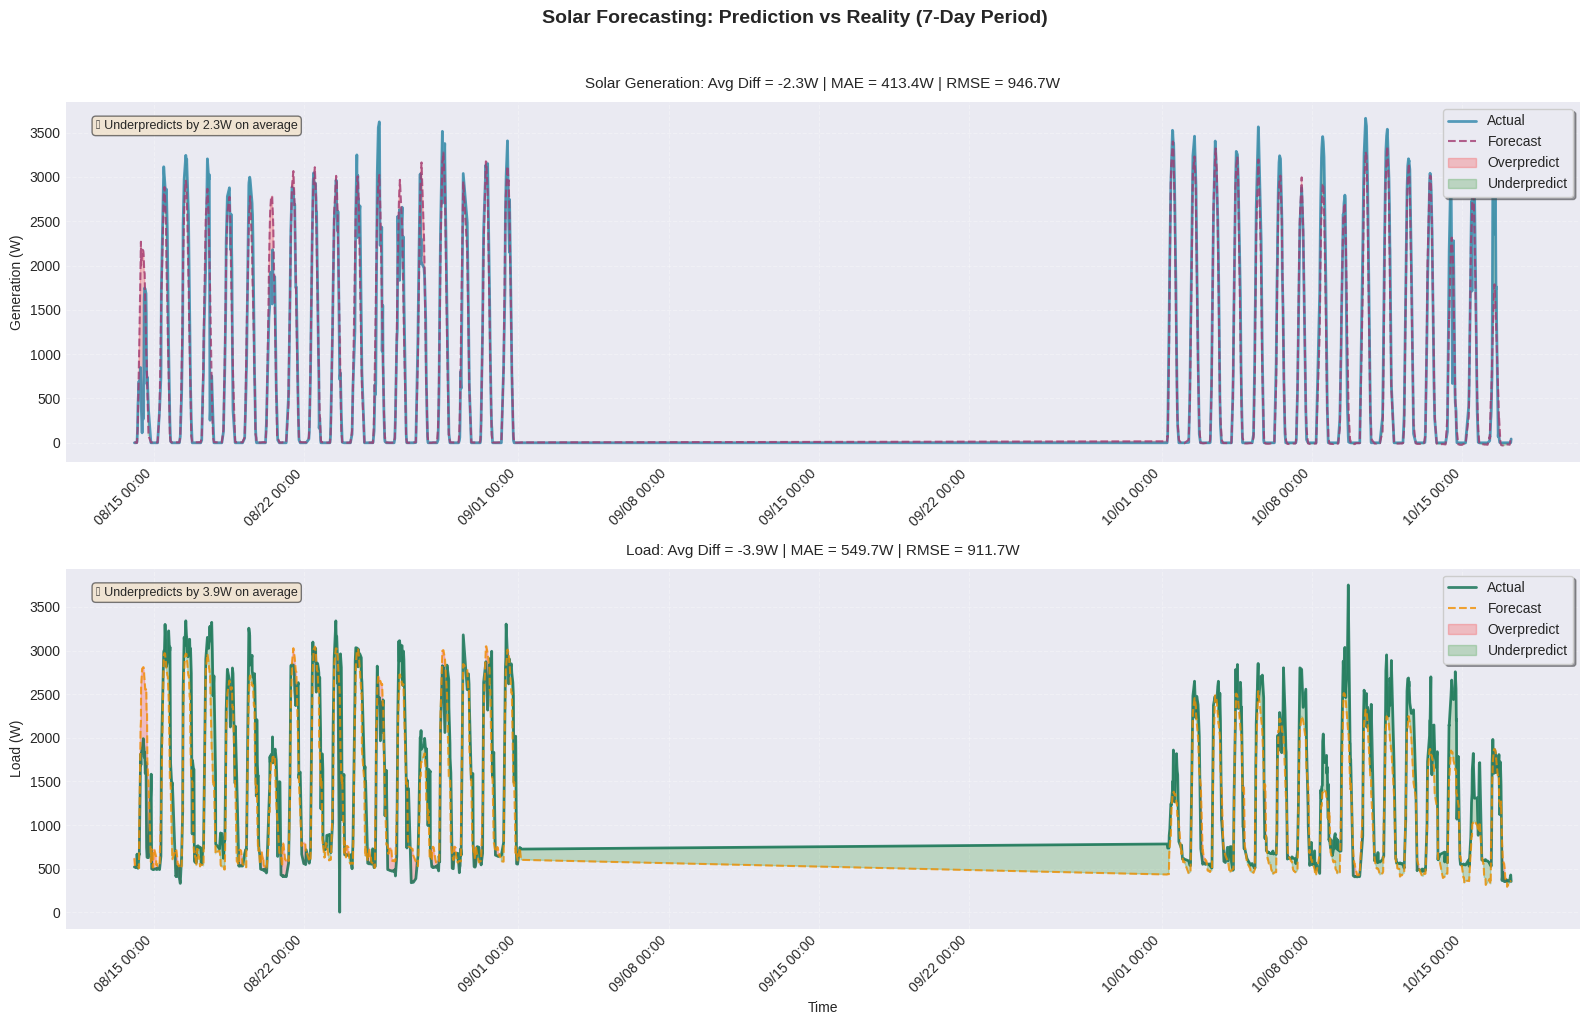

✅ Visualization saved as 'forecast_vs_actual_stacking.png'

ERROR PATTERN ANALYSIS

🔍 Generation Error Patterns:
   🕐 Worst prediction hours: [12, 11, 13] (Avg MAE: 1149.35 W)
   ⬆️ Tends to overpredict at hours: [15, 7, 16]
   ⬇️ Tends to underpredict at hours: [13, 18, 19]
   📈 Error on high capacity systems: MAE = 576.24 W
   📉 Error on low capacity systems: MAE = 271.64 W

🔍 Load Error Patterns:
   🕐 Worst prediction hours: [15, 16, 13] (Avg MAE: 678.22 W)
   ⬆️ Tends to overpredict at hours: [17, 12, 13]
   ⬇️ Tends to underpredict at hours: [6, 2, 5]
   📈 Error on high capacity systems: MAE = 652.91 W
   📉 Error on low capacity systems: MAE = 459.77 W


In [15]:
# ============================================
# 8. VALIDATION ANALYSIS & VISUALIZATION
# ============================================

print("\n" + "="*60)
print("VALIDATION ANALYSIS - FORECAST VS ACTUAL")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Use validation indices from the last fold
val_indices = lgb_gen_val_idx  # From the last LightGBM generation fold
X_val_analysis = X_train.iloc[val_indices]
y_gen_val = y_train_gen.iloc[val_indices]
y_load_val = y_train_load.iloc[val_indices]

# Get ensemble predictions for validation set
val_meta_gen = []
val_meta_load = []

# LightGBM validation predictions
lgb_val_gen = np.mean([m.predict(X_val_analysis, num_iteration=m.best_iteration)
                       for m in lgb_gen_models], axis=0)
lgb_val_load = np.mean([m.predict(X_val_analysis, num_iteration=m.best_iteration)
                        for m in lgb_load_models], axis=0)
lgb_val_gen_std = np.std([m.predict(X_val_analysis) for m in lgb_gen_models], axis=0)
lgb_val_load_std = np.std([m.predict(X_val_analysis) for m in lgb_load_models], axis=0)

val_meta_gen.extend([lgb_val_gen, lgb_val_gen_std])
val_meta_load.extend([lgb_val_load, lgb_val_load_std])

if USE_XGBOOST:
    xgb_val_gen = np.mean([m.predict(X_val_analysis) for m in xgb_gen_models], axis=0)
    xgb_val_load = np.mean([m.predict(X_val_analysis) for m in xgb_load_models], axis=0)
    xgb_val_gen_std = np.std([m.predict(X_val_analysis) for m in xgb_gen_models], axis=0)
    xgb_val_load_std = np.std([m.predict(X_val_analysis) for m in xgb_load_models], axis=0)
    val_meta_gen.extend([xgb_val_gen, xgb_val_gen_std])
    val_meta_load.extend([xgb_val_load, xgb_val_load_std])

if USE_CATBOOST:
    cb_val_gen = np.mean([m.predict(X_val_analysis) for m in cb_gen_models], axis=0)
    cb_val_load = np.mean([m.predict(X_val_analysis) for m in cb_load_models], axis=0)
    cb_val_gen_std = np.std([m.predict(X_val_analysis) for m in cb_gen_models], axis=0)
    cb_val_load_std = np.std([m.predict(X_val_analysis) for m in cb_load_models], axis=0)
    val_meta_gen.extend([cb_val_gen, cb_val_gen_std])
    val_meta_load.extend([cb_val_load, cb_val_load_std])

# Get stacked predictions for validation
X_meta_val_gen = np.column_stack(val_meta_gen)
X_meta_val_load = np.column_stack(val_meta_load)

stacked_val_gen = meta_model_gen.predict(X_meta_val_gen)
stacked_val_load = meta_model_load.predict(X_meta_val_load)

# Denormalize for actual comparison
val_data = train_processed.iloc[val_indices]
actual_gen = y_gen_val.values * val_data['panels_capacity_W'].values
actual_load = y_load_val.values * val_data['load_capacity_W'].values
pred_gen = stacked_val_gen * val_data['panels_capacity_W'].values
pred_load = stacked_val_load * val_data['load_capacity_W'].values

# Calculate evaluation metrics
def calculate_metrics(actual, predicted, name):
    mae = np.mean(np.abs(actual - predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    avg_diff = np.mean(predicted - actual)

    print(f"\n📊 {name} Metrics:")
    print(f"   MAE (Mean Absolute Error): {mae:.2f} W")
    print(f"   RMSE: {rmse:.2f} W")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Average Difference (Pred - Actual): {avg_diff:.2f} W")
    print(f"   {'⬆️ Tends to overpredict' if avg_diff > 0 else '⬇️ Tends to underpredict'}")

    # Analyze when model is wrong
    errors = np.abs(actual - predicted)
    high_error_idx = errors > np.percentile(errors, 90)

    if 'hour' in val_data.columns:
        high_error_hours = val_data.iloc[high_error_idx]['hour'].value_counts().head(3)
        print(f"   ⚠️ Most errors occur at hours: {high_error_hours.index.tolist()}")

    return mae, mape, rmse, avg_diff

# Calculate and print metrics
gen_mae, gen_mape, gen_rmse, gen_avg_diff = calculate_metrics(actual_gen, pred_gen, "Generation")
load_mae, load_mape, load_rmse, load_avg_diff = calculate_metrics(actual_load, pred_load, "Load")

# Print sample results
print("\n" + "="*60)
print("📁 SAMPLE VALIDATION RESULTS (First 5 predictions)")
print("="*60)
for i in range(min(5, len(actual_gen))):
    print(f"\n🔍 Sample {i+1}:")
    print(f"  Generation:")
    print(f"    Actual: {actual_gen[i]:8.2f} W")
    print(f"    Predicted: {pred_gen[i]:8.2f} W")
    print(f"    Difference: {pred_gen[i]-actual_gen[i]:8.2f} W ({'+' if pred_gen[i] > actual_gen[i] else ''}{((pred_gen[i]-actual_gen[i])/actual_gen[i]*100):.1f}%)")
    print(f"  Load:")
    print(f"    Actual: {actual_load[i]:8.2f} W")
    print(f"    Predicted: {pred_load[i]:8.2f} W")
    print(f"    Difference: {pred_load[i]-actual_load[i]:8.2f} W ({'+' if pred_load[i] > actual_load[i] else ''}{((pred_load[i]-actual_load[i])/actual_load[i]*100):.1f}%)")

# ============================================
# VISUALIZATION: FORECAST VS ACTUAL
# ============================================

print("\n" + "="*60)
print("CREATING FORECAST VS ACTUAL VISUALIZATION")
print("="*60)

# Select a 7-day period for visualization
period_length = min(7 * 24 * 6, len(actual_gen))  # 7 days at 10-min intervals
viz_slice = slice(0, period_length)

# Create time index for x-axis
if 'timestamp' in val_data.columns:
    time_index = pd.to_datetime(val_data['timestamp'].iloc[viz_slice])
else:
    # Create synthetic time index if timestamp not available
    start_date = '2023-01-01'
    time_index = pd.date_range(start=start_date, periods=period_length, freq='10min')

# Create overlay chart with improved styling
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Solar Forecasting: Prediction vs Reality (7-Day Period)', fontsize=14, fontweight='bold', y=1.02)

# Generation subplot
ax1.plot(time_index, actual_gen[viz_slice], label='Actual', color='#2E86AB', alpha=0.8, linewidth=2)
ax1.plot(time_index, pred_gen[viz_slice], label='Forecast', color='#A23B72', alpha=0.8, linewidth=1.5, linestyle='--')
ax1.fill_between(time_index, actual_gen[viz_slice], pred_gen[viz_slice],
                  where=(pred_gen[viz_slice] > actual_gen[viz_slice]),
                  alpha=0.2, color='red', label='Overpredict')
ax1.fill_between(time_index, actual_gen[viz_slice], pred_gen[viz_slice],
                  where=(pred_gen[viz_slice] <= actual_gen[viz_slice]),
                  alpha=0.2, color='green', label='Underpredict')

ax1.set_title(f'Solar Generation: Avg Diff = {gen_avg_diff:.1f}W | MAE = {gen_mae:.1f}W | RMSE = {gen_rmse:.1f}W',
              fontsize=11, pad=10)
ax1.set_ylabel('Generation (W)', fontsize=10)
ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:00'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add text annotation for average difference
ax1.text(0.02, 0.95, f"{'📈 Overpredicts' if gen_avg_diff > 0 else '📉 Underpredicts'} by {abs(gen_avg_diff):.1f}W on average",
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Load subplot
ax2.plot(time_index, actual_load[viz_slice], label='Actual', color='#0B6E4F', alpha=0.8, linewidth=2)
ax2.plot(time_index, pred_load[viz_slice], label='Forecast', color='#F18F01', alpha=0.8, linewidth=1.5, linestyle='--')
ax2.fill_between(time_index, actual_load[viz_slice], pred_load[viz_slice],
                  where=(pred_load[viz_slice] > actual_load[viz_slice]),
                  alpha=0.2, color='red', label='Overpredict')
ax2.fill_between(time_index, actual_load[viz_slice], pred_load[viz_slice],
                  where=(pred_load[viz_slice] <= actual_load[viz_slice]),
                  alpha=0.2, color='green', label='Underpredict')

ax2.set_title(f'Load: Avg Diff = {load_avg_diff:.1f}W | MAE = {load_mae:.1f}W | RMSE = {load_rmse:.1f}W',
              fontsize=11, pad=10)
ax2.set_xlabel('Time', fontsize=10)
ax2.set_ylabel('Load (W)', fontsize=10)
ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:00'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add text annotation for average difference
ax2.text(0.02, 0.95, f"{'📈 Overpredicts' if load_avg_diff > 0 else '📉 Underpredicts'} by {abs(load_avg_diff):.1f}W on average",
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('forecast_vs_actual_stacking.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'forecast_vs_actual_stacking.png'")

# ============================================
# ERROR PATTERN ANALYSIS
# ============================================

print("\n" + "="*60)
print("ERROR PATTERN ANALYSIS")
print("="*60)

def analyze_error_patterns(actual, predicted, data_subset, name):
    errors = predicted - actual
    abs_errors = np.abs(errors)

    print(f"\n🔍 {name} Error Patterns:")

    # Hour of day analysis
    if 'hour' in data_subset.columns:
        hourly_errors = pd.DataFrame({
            'hour': data_subset['hour'].values,
            'error': errors,
            'abs_error': abs_errors
        })
        hourly_avg = hourly_errors.groupby('hour')['error'].mean()
        hourly_mae = hourly_errors.groupby('hour')['abs_error'].mean()

        worst_hours = hourly_mae.nlargest(3)
        print(f"   🕐 Worst prediction hours: {worst_hours.index.tolist()} (Avg MAE: {worst_hours.values.mean():.2f} W)")

        overpredict_hours = hourly_avg[hourly_avg > 0].nlargest(3)
        if len(overpredict_hours) > 0:
            print(f"   ⬆️ Tends to overpredict at hours: {overpredict_hours.index.tolist()}")

        underpredict_hours = hourly_avg[hourly_avg < 0].nsmallest(3)
        if len(underpredict_hours) > 0:
            print(f"   ⬇️ Tends to underpredict at hours: {underpredict_hours.index.tolist()}")

    # Capacity-based analysis
    if 'panels_capacity_W' in data_subset.columns:
        high_capacity = data_subset['panels_capacity_W'].values > data_subset['panels_capacity_W'].median()
        print(f"   📈 Error on high capacity systems: MAE = {abs_errors[high_capacity].mean():.2f} W")
        print(f"   📉 Error on low capacity systems: MAE = {abs_errors[~high_capacity].mean():.2f} W")

analyze_error_patterns(actual_gen, pred_gen, val_data, "Generation")
analyze_error_patterns(actual_load, pred_load, val_data, "Load")

# PREDICTION AND SUBMISSION

In [16]:
# ============================================
# 8. GENERATE TEST PREDICTIONS
# ============================================

print("\n" + "="*60)
print("GENERATING TEST PREDICTIONS")
print("="*60)

# Create meta features for test
meta_test_gen = []
meta_test_load = []

# LightGBM test predictions
lgb_test_gen = np.mean([m.predict(X_test, num_iteration=m.best_iteration)
                        for m in lgb_gen_models], axis=0)
lgb_test_load = np.mean([m.predict(X_test, num_iteration=m.best_iteration)
                         for m in lgb_load_models], axis=0)

# For stacking
lgb_test_gen_std = np.std([m.predict(X_test)
                           for m in lgb_gen_models], axis=0)
lgb_test_load_std = np.std([m.predict(X_test)
                            for m in lgb_load_models], axis=0)

meta_test_gen.extend([lgb_test_gen, lgb_test_gen_std])
meta_test_load.extend([lgb_test_load, lgb_test_load_std])

if USE_XGBOOST:
    xgb_test_gen = np.mean([m.predict(X_test) for m in xgb_gen_models], axis=0)
    xgb_test_load = np.mean([m.predict(X_test) for m in xgb_load_models], axis=0)
    xgb_test_gen_std = np.std([m.predict(X_test) for m in xgb_gen_models], axis=0)
    xgb_test_load_std = np.std([m.predict(X_test) for m in xgb_load_models], axis=0)
    meta_test_gen.extend([xgb_test_gen, xgb_test_gen_std])
    meta_test_load.extend([xgb_test_load, xgb_test_load_std])

if USE_CATBOOST:
    cb_test_gen = np.mean([m.predict(X_test) for m in cb_gen_models], axis=0)
    cb_test_load = np.mean([m.predict(X_test) for m in cb_load_models], axis=0)
    cb_test_gen_std = np.std([m.predict(X_test) for m in cb_gen_models], axis=0)
    cb_test_load_std = np.std([m.predict(X_test) for m in cb_load_models], axis=0)
    meta_test_gen.extend([cb_test_gen, cb_test_gen_std])
    meta_test_load.extend([cb_test_load, cb_test_load_std])

# Get stacked predictions
X_meta_test_gen = np.column_stack(meta_test_gen)
X_meta_test_load = np.column_stack(meta_test_load)

stacked_gen_pred = meta_model_gen.predict(X_meta_test_gen)
stacked_load_pred = meta_model_load.predict(X_meta_test_load)

# Also calculate simple average (often works well)
if USE_XGBOOST and USE_CATBOOST:
    avg_gen_pred = (lgb_test_gen + xgb_test_gen + cb_test_gen) / 3
    avg_load_pred = (lgb_test_load + xgb_test_load + cb_test_load) / 3
elif USE_XGBOOST:
    avg_gen_pred = (lgb_test_gen + xgb_test_gen) / 2
    avg_load_pred = (lgb_test_load + xgb_test_load) / 2
else:
    avg_gen_pred = lgb_test_gen
    avg_load_pred = lgb_test_load

# Choose best ensemble method (you can experiment)
USE_STACKING = True  # Set to False to use simple average

if USE_STACKING:
    final_gen_normalized = stacked_gen_pred
    final_load_normalized = stacked_load_pred
    print("Using stacked predictions")
else:
    final_gen_normalized = avg_gen_pred
    final_load_normalized = avg_load_pred
    print("Using averaged predictions")

# ============================================
# 9. DENORMALIZE AND CREATE SUBMISSION
# ============================================

print("\n" + "="*60)
print("CREATING SUBMISSION")
print("="*60)

# Denormalize predictions
final_gen_pred = final_gen_normalized * test_processed['panels_capacity_W'].values
final_load_pred = final_load_normalized * test_processed['load_capacity_W'].values

# Ensure non-negative
final_gen_pred = np.maximum(0, final_gen_pred)
final_load_pred = np.maximum(0, final_load_pred)

print(f"Generation range: {final_gen_pred.min():.2f} - {final_gen_pred.max():.2f} W")
print(f"Load range: {final_load_pred.min():.2f} - {final_load_pred.max():.2f} W")

# Create submission
submission = test_df_original[['test_id', 'generation_W', 'load_W']].copy()

# Replace -1 values
mask_gen_predict = (submission['generation_W'] == -1)
mask_load_predict = (submission['load_W'] == -1)

submission.loc[mask_gen_predict, 'generation_W'] = final_gen_pred[mask_gen_predict]
submission.loc[mask_load_predict, 'load_W'] = final_load_pred[mask_load_predict]

# Handle -2 values
if (sample_submission['generation_W'] < 0).sum() == 0:
    submission.loc[submission['generation_W'] == -2, 'generation_W'] = 0
    submission.loc[submission['load_W'] == -2, 'load_W'] = 0

# Ensure match with sample submission
final_submission = sample_submission[['test_id']].merge(
    submission, on='test_id', how='left'
)

for col in ['generation_W', 'load_W']:
    if col in sample_submission.columns:
        final_submission[col] = final_submission[col].fillna(sample_submission[col])
    final_submission[col] = final_submission[col].fillna(0.0).clip(lower=0)

# Save
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_filename = f'submission_stacked_{timestamp}.csv'
final_submission.to_csv(submission_filename, index=False)
final_submission.to_csv('submission_stacked.csv', index=False)

print(f"✅ Submission saved as: {submission_filename}")


GENERATING TEST PREDICTIONS
Using stacked predictions

CREATING SUBMISSION
Generation range: 0.00 - 19831.91 W
Load range: 0.00 - 8900.76 W
✅ Submission saved as: submission_stacked_20250826_212902.csv


# CONLCUSION

In [17]:
# ============================================
# 10. FEATURE IMPORTANCE ANALYSIS
# ============================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

# Get average feature importance from LightGBM models
importance_gen = np.mean([m.feature_importance(importance_type='gain')
                          for m in lgb_gen_models], axis=0)
importance_load = np.mean([m.feature_importance(importance_type='gain')
                           for m in lgb_load_models], axis=0)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_gen': importance_gen,
    'importance_load': importance_load,
    'importance_avg': (importance_gen + importance_load) / 2
}).sort_values('importance_avg', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(importance_df.head(15)[['feature', 'importance_avg']])

# Save importance for analysis
importance_df.to_csv('feature_importance.csv', index=False)

print("\n" + "="*60)
print("✅ ADVANCED STACKING PIPELINE COMPLETE!")
print("="*60)

print(f"""
📊 Models Used:
- LightGBM: {len(lgb_gen_models)} folds
{"- XGBoost: " + str(len(xgb_gen_models)) + " folds" if USE_XGBOOST else ""}
{"- CatBoost: " + str(len(cb_gen_models)) + " folds" if USE_CATBOOST else ""}
- Meta-learner: {"Stacking with Ridge" if USE_STACKING else "Simple Average"}
""")


FEATURE IMPORTANCE

📊 Top 15 Most Important Features:
                  feature  importance_avg
42      minutes_from_noon   414639.457758
43  minutes_from_midnight   321619.514364
16        solar_intensity    98037.148062
0       panels_capacity_W    94014.962098
12                day_cos    83657.995348
24         capacity_ratio    83586.484353
4             day_of_year    42046.121837
10               hour_cos    32380.548384
11                day_sin    32238.165423
14              month_cos    31935.229122
25    log_panels_capacity    23402.041698
33            loc_KARACHI    18846.581816
36         loc_RAWALPINDI    16293.842379
40               loc_SWAT    15500.783400
34          loc_ISLAMABAD    13940.949089

✅ ADVANCED STACKING PIPELINE COMPLETE!

📊 Models Used:
- LightGBM: 5 folds
- XGBoost: 5 folds
- CatBoost: 3 folds
- Meta-learner: Stacking with Ridge

